In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import glob
import numpy as np
from h5py import File
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.interfaces import opal,elegant
#from pmd_beamphysics.plot import slice_plot
from pmd_beamphysics.statistics import slice_statistics
from  pmd_beamphysics.units import nice_array, nice_scale_prefix

In [3]:
def getCurrent(t, p, Q, Nbin=300):
    Np = len(t);
    nn,tbin_edge = np.histogram(t,Nbin);
    dt = tbin_edge[1] - tbin_edge[0];  #in matlab, distance btwn bin centers
    I = nn*Q/Np/dt
    ts = tbin_edge+dt/2
    return ts[:Nbin],I

In [4]:
def slice_plot(particle_group, stat_key='sigma_x', n_slice=40, slice_key='z', ax = None):
    """
    Complete slice plotting routine. Will plot the density of the slice key on the right axis. 
    """
    
    x_key = 'mean_'+slice_key
    y_key = stat_key
    slice_dat = slice_statistics(particle_group, n_slice=n_slice, slice_key=slice_key,
                            keys=[x_key, y_key, 'ptp_'+slice_key, 'charge'])
    
    
    slice_dat['density'] = slice_dat['charge']/ slice_dat['ptp_'+slice_key]
    y2_key = 'density'
    if ax == None:
        fig, ax = plt.subplots()
    ax.cla()
    
    # Get nice arrays
    x, _, prex = nice_array(slice_dat[x_key])
    y, _, prey = nice_array(slice_dat[y_key])
    y2, _, prey2 = nice_array(slice_dat[y2_key])
    
    # Add prefix to units
    x_units = prex+particle_group.units(x_key).unitSymbol
    y_units = prey+particle_group.units(y_key).unitSymbol
    
    # Convert to Amps if possible
    y2_units = f'C/{particle_group.units(x_key)}'
    if y2_units == 'C/s':
        y2_units = 'A'
    y2_units = prey2+y2_units 
    
    # Labels
    ax.set_xlabel(f'{x_key} ({x_units})' )
    ax.set_ylabel(f'{y_key} ({y_units})' )
    
    # Main plot
    ax.plot(x, y, color = 'black')
    
    #ax.set_ylim(0, 1.1*ymax )

    ax2 = ax.twinx()
    ax2.set_ylabel(f'{y2_key} ({y2_units})' )
    ax2.fill_between(x, 0, y2, color='black', alpha = 0.2)

In [5]:
def parse_stat(filename, names = ['t', 's','nPart','charge','energy','rms_x', 'rms_y', 'rms_s', \
                                 'rms_px', 'rms_py', 'rms_ps', 'emit_x', 'emit_y', 'emit_s', 'mean_x', \
                                 'mean_y', 'mean_s', 'ref_x', 'ref_y', 'ref_z', 'ref_px', 'ref_py', 'ref_pz', \
                                 'max_x', 'max_y', 'max_s', 'xpx', 'ypy', 'zpz', 'Dx', 'DDx', 'Dy', 'DDy', \
                                 'Bx_ref', 'By_ref', 'Bz_ref', 'Ex_ref', 'Ey_ref', 'Ez_ref', 'dE', 'dt', 'partsOutside',\
                                 'DebyeLength', 'plasmaParameter', 'temperature', 'rmsDensity']):
    dist = {}
    data = np.loadtxt(filename, skiprows=303)
    for i,name in enumerate(names):
        dist[name] = data[:,i]
        
    print('get better parser from nicole')
    return dist

In [6]:
def parse_opal_emitted_dist(filename, names=['x', 'px','y','py','t','pz']):
    '''Read in particle distribution used 
    in OPAL-T simulation. Used to describe the 
    beam distribution as it leaves the cathode.'''
    dist = {}
    data = np.loadtxt(filename, skiprows=1)
    for i,name in enumerate(names):
        dist[name] = data[:,i]
    return dist

In [7]:
def old_parse_stat(filename, names = ['t', 's','nPart','charge','energy','rms_x', 'rms_y', 'rms_s', \
                                 'rms_px', 'rms_py', 'rms_ps', 'emit_x', 'emit_y', 'emit_s', 'mean_x', \
                                 'mean_y', 'mean_s', 'ref_x', 'ref_y', 'ref_z', 'ref_px', 'ref_py', 'ref_pz', \
                                 'max_x', 'max_y', 'max_s', 'xpx', 'ypy', 'zpz', 'Dx', 'DDx', 'Dy', 'DDy', \
                                 'Bx_ref', 'By_ref', 'Bz_ref', 'Ex_ref', 'Ey_ref', 'Ez_ref', 'dE', 'dt', 'partsOutside']):
    dist = {}
    data = np.loadtxt(filename, skiprows=279)
    for i,name in enumerate(names):
        dist[name] = data[:,i]
    
    print('get better parser from nicole')
    return dist

In [8]:
basedir = os.getcwd()

In [75]:
simdirs = ['/sdf/data/ad/ard/u/paris/Cathode_shaping/test2/sim0/', '/sdf/data/ad/ard/u/paris/Cathode_shaping/centos_sim0/',\
          '/sdf/data/ad/ard/u/paris/Cathode_shaping/benchmark_sim0/',\
          '/sdf/data/ad/ard/u/paris/Cathode_shaping/1pert_2pS_position5_100pC/sim0',\
          '/sdf/data/ad/ard/u/paris/Cathode_shaping/benchmark_sim0_different_dist/']


/sdf/data/ad/ard/u/paris/Cathode_shaping/test2/sim0/
get better parser from nicole
nPart = 50000
emit_x = 0.79 um
rms_x = 0.16 mm
rms_s = 0.99 mm
energy = 96.55 MeV
/sdf/data/ad/ard/u/paris/Cathode_shaping/centos_sim0/
get better parser from nicole
nPart = 5000000
emit_x = 0.54 um
rms_x = 0.16 mm
rms_s = 1.03 mm
energy = 96.55 MeV
/sdf/data/ad/ard/u/paris/Cathode_shaping/benchmark_sim0/
get better parser from nicole
nPart = 5000000
emit_x = 0.54 um
rms_x = 0.16 mm
rms_s = 1.03 mm
energy = 96.55 MeV
/sdf/data/ad/ard/u/paris/Cathode_shaping/1pert_2pS_position5_100pC/sim0
get better parser from nicole
nPart = 5000000
emit_x = 0.54 um
rms_x = 0.16 mm
rms_s = 1.03 mm
energy = 96.55 MeV
/sdf/data/ad/ard/u/paris/Cathode_shaping/benchmark_sim0_different_dist/
get better parser from nicole
nPart = 5000000
emit_x = 0.81 um
rms_x = 0.11 mm
rms_s = 0.96 mm
energy = 96.55 MeV


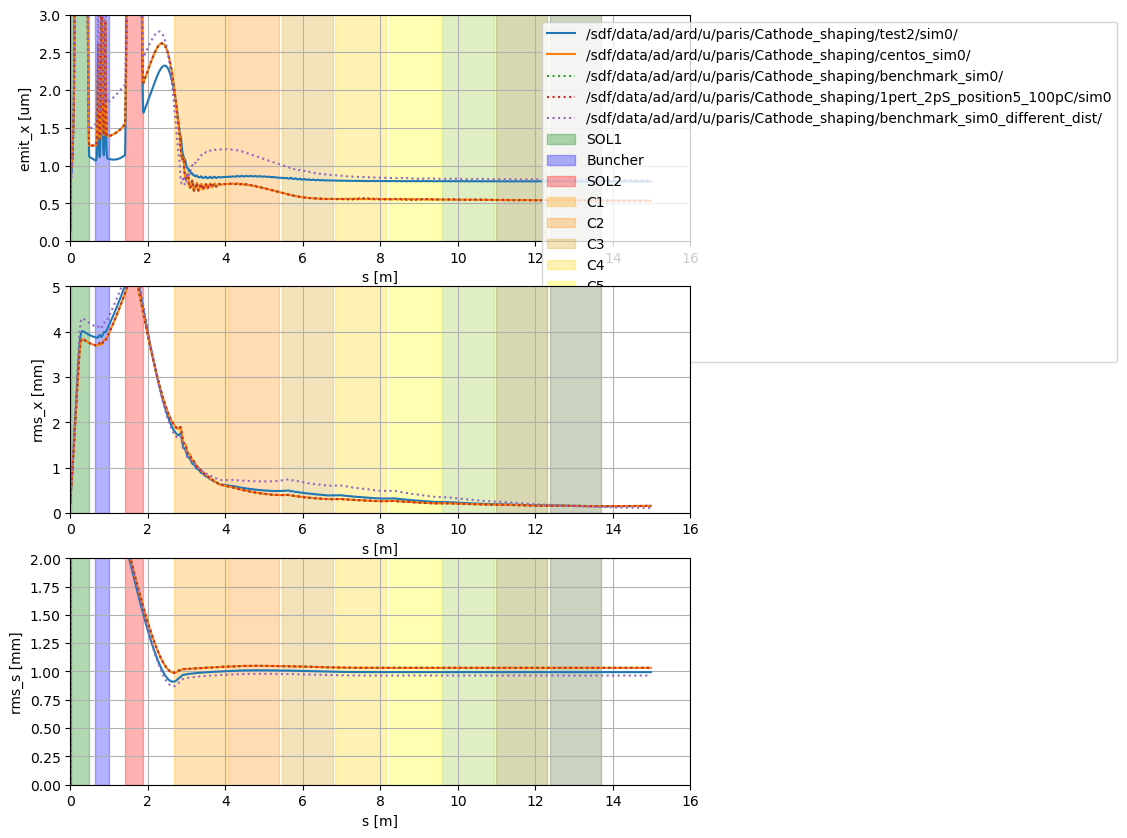

In [78]:
xmeter = 16

#fig, ax = plt.subplots(figsize = (12,5))
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8,10))
for ii in range(len(simdirs)):
    os.chdir(simdirs[ii])
    print(simdirs[ii])
    try:
        stat = parse_stat('sc_inj.stat')
    except:
        stat = old_parse_stat('sc_inj.stat')

    if (ii==2) | (ii==3) |(ii==4): linetype = ':'
    else: linetype = '-'
    ax[0].plot(stat['s'], stat['emit_x']*1e6, label = simdirs[ii], linestyle = linetype)
    ax[1].plot(stat['s'], stat['rms_x']*1e3, label = simdirs[ii], linestyle = linetype)
    ax[2].plot(stat['s'], stat['rms_s']*1e3, label = simdirs[ii], linestyle = linetype)

    print('nPart = %1.0f' %(stat['nPart'][-1]))
    print('emit_x = %1.2f um' %(stat['emit_x'][-1]*1e6))
    print('rms_x = %1.2f mm' %(stat['rms_x'][-1]*1e3))
    print('rms_s = %1.2f mm' %(stat['rms_s'][-1]*1e3))
    print('energy = %1.2f MeV' %(stat['energy'][-1]))
    



ax[0].fill_between([0.00653,0.48653], 0,100, color='green', alpha=0.3, label = 'SOL1')
ax[0].fill_between([0.6300495,0.9881825], 0,100, color='blue', alpha=0.3, label = 'Buncher')
ax[0].fill_between([1.40581,1.88581], 0,100, color='red', alpha=0.3, label = 'SOL2')
ax[0].fill_between([2.6833989, 4.0021969], 0,100, color='orange', alpha=0.3, label = 'C1')
ax[0].fill_between([4.0669989, 5.3857969], 0,100, color='darkorange', alpha=0.3, label = 'C2')
ax[0].fill_between([5.4505989, 6.7693969], 0,100, color='goldenrod', alpha=0.3, label = 'C3')
ax[0].fill_between([6.8341989, 8.1529969], 0,100, color='gold', alpha=0.3, label = 'C4')
ax[0].fill_between([8.2177989, 9.5365969], 0,100, color='yellow', alpha=0.3, label = 'C5')
ax[0].fill_between([9.6013989, 10.9201969], 0,100, color='yellowgreen', alpha=0.3, label = 'C6')
ax[0].fill_between([10.9849989, 12.3037969], 0,100, color='olive', alpha=0.3, label = 'C7')
ax[0].fill_between([12.3685989, 13.6873969], 0,100, color='darkolivegreen', alpha=0.3, label = 'C8')
ax[0].set_xlabel('s [m]')

#lines_str = [str(x) for x in best_sort] + ['SOL1', 'Buncher', 'SOL2', 'C1'] #, 'C2', 'C3', 'C4', \
          #'C5', 'C6', 'C7', 'C8']
ax[0].legend(loc = 1, bbox_to_anchor = [1.7, 1])
                      
#ax.legend( lines_str, loc = 'upper left')
#ax.set_ylabel('emit_x [um]')
ax[0].set_ylabel('emit_x [um]')
ax[0].set_ylim((0,3))
ax[0].set_xlim((0,xmeter)) #

ax[1].fill_between([0.00653,0.48653], 0,100, color='green', alpha=0.3, label = 'SOL1')
ax[1].fill_between([0.6300495,0.9881825], 0,100, color='blue', alpha=0.3, label = 'Buncher')
ax[1].fill_between([1.40581,1.88581], 0,100, color='red', alpha=0.3, label = 'SOL2')
ax[1].fill_between([2.6833989, 4.0021969], 0,100, color='orange', alpha=0.3, label = 'C1')
ax[1].fill_between([4.0669989, 5.3857969], 0,100, color='darkorange', alpha=0.3, label = 'C2')
ax[1].fill_between([5.4505989, 6.7693969], 0,100, color='goldenrod', alpha=0.3, label = 'C3')
ax[1].fill_between([6.8341989, 8.1529969], 0,100, color='gold', alpha=0.3, label = 'C4')
ax[1].fill_between([8.2177989, 9.5365969], 0,100, color='yellow', alpha=0.3, label = 'C5')
ax[1].fill_between([9.6013989, 10.9201969], 0,100, color='yellowgreen', alpha=0.3, label = 'C6')
ax[1].fill_between([10.9849989, 12.3037969], 0,100, color='olive', alpha=0.3, label = 'C7')
ax[1].fill_between([12.3685989, 13.6873969], 0,100, color='darkolivegreen', alpha=0.3, label = 'C8')
ax[1].set_xlabel('s [m]')
ax[1].set_ylim((0,5))
ax[1].set_xlim((0,xmeter))
#ax[1].legend()
ax[1].set_ylabel('rms_x [mm]')

ax[2].fill_between([0.00653,0.48653], 0,100, color='green', alpha=0.3, label = 'SOL1')
ax[2].fill_between([0.6300495,0.9881825], 0,100, color='blue', alpha=0.3, label = 'Buncher')
ax[2].fill_between([1.40581,1.88581], 0,100, color='red', alpha=0.3, label = 'SOL2')
ax[2].fill_between([2.6833989, 4.0021969], 0,100, color='orange', alpha=0.3, label = 'C1')
ax[2].fill_between([4.0669989, 5.3857969], 0,100, color='darkorange', alpha=0.3, label = 'C2')
ax[2].fill_between([5.4505989, 6.7693969], 0,100, color='goldenrod', alpha=0.3, label = 'C3')
ax[2].fill_between([6.8341989, 8.1529969], 0,100, color='gold', alpha=0.3, label = 'C4')
ax[2].fill_between([8.2177989, 9.5365969], 0,100, color='yellow', alpha=0.3, label = 'C5')
ax[2].fill_between([9.6013989, 10.9201969], 0,100, color='yellowgreen', alpha=0.3, label = 'C6')
ax[2].fill_between([10.9849989, 12.3037969], 0,100, color='olive', alpha=0.3, label = 'C7')
ax[2].fill_between([12.3685989, 13.6873969], 0,100, color='darkolivegreen', alpha=0.3, label = 'C8')
ax[2].set_xlabel('s [m]')
ax[2].set_xlabel('s [m]')
ax[2].set_ylim((0,2))
ax[2].set_xlim((0,xmeter))
#ax.legend()
ax[2].set_ylabel('rms_s [mm]')

ax[0].grid()
ax[1].grid()
ax[2].grid()



os.chdir(basedir)

/sdf/data/ad/ard/u/paris/Cathode_shaping/test2/sim0/
get better parser from nicole
nPart = 50000
emit_x_0 = 0.1345 um
emit_x = 0.79 um
rms_x = 0.16 mm
rms_s = 0.99 mm
energy = 96.55 MeV
energy0 = 0.000018850 MeV
/sdf/data/ad/ard/u/paris/Cathode_shaping/centos_sim0/
get better parser from nicole
nPart = 5000000
emit_x_0 = 0.2007 um
emit_x = 0.54 um
rms_x = 0.16 mm
rms_s = 1.03 mm
energy = 96.55 MeV
energy0 = 0.000018872 MeV
/sdf/data/ad/ard/u/paris/Cathode_shaping/benchmark_sim0/
get better parser from nicole
nPart = 5000000
emit_x_0 = 0.2007 um
emit_x = 0.54 um
rms_x = 0.16 mm
rms_s = 1.03 mm
energy = 96.55 MeV
energy0 = 0.000018872 MeV
/sdf/data/ad/ard/u/paris/Cathode_shaping/1pert_2pS_position5_100pC_comp_on/sim0
get better parser from nicole
nPart = 5000000
emit_x_0 = 0.1412 um
emit_x = 0.81 um
rms_x = 0.11 mm
rms_s = 0.96 mm
energy = 96.55 MeV
energy0 = 0.000018464 MeV
/sdf/data/ad/ard/u/paris/Cathode_shaping/benchmark_sim0_different_dist/
get better parser from nicole
nPart = 5000

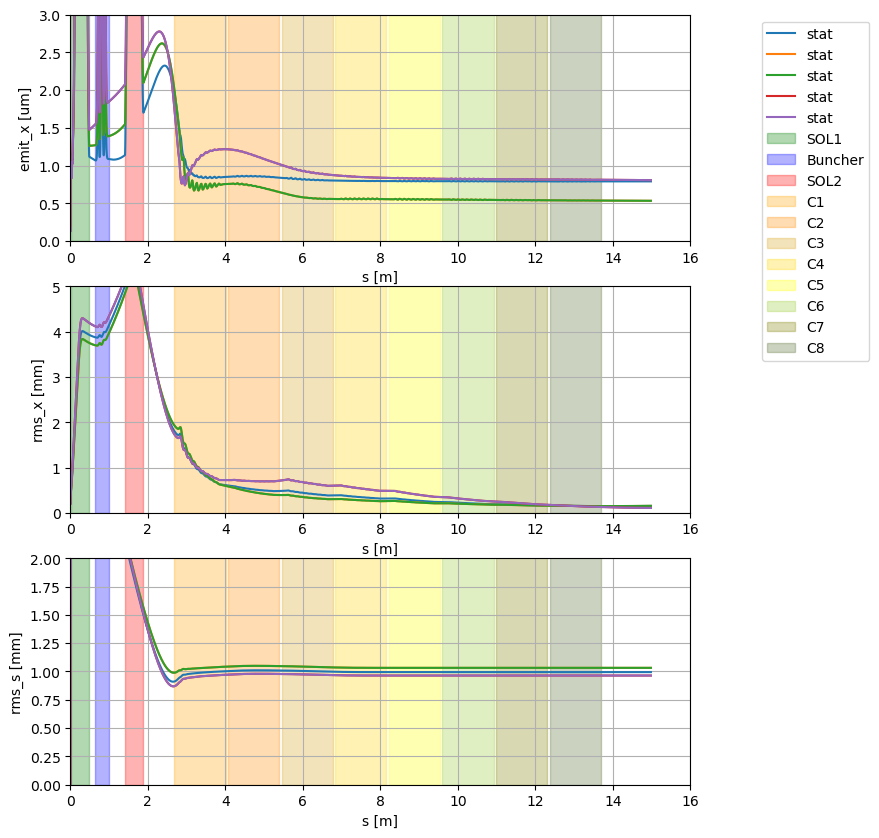

In [56]:
xmeter = 16

#fig, ax = plt.subplots(figsize = (12,5))
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (8,10))
for ii in range(len(simdirs)):
    os.chdir(simdirs[ii])
    print(simdirs[ii])
    try:
        stat = parse_stat('sc_inj.stat')
    except:
        stat = old_parse_stat('sc_inj.stat')
        
    ax[0].plot(stat['s'], stat['emit_x']*1e6, label = 'stat')
    ax[1].plot(stat['s'], stat['rms_x']*1e3, label = 'stat')
    ax[2].plot(stat['s'], stat['rms_s']*1e3, label = 'stat')

    print('nPart = %1.0f' %(stat['nPart'][-1]))
    print('emit_x_0 = %1.4f um' %(stat['emit_x'][0]*1e6))
    print('emit_x = %1.2f um' %(stat['emit_x'][-1]*1e6))
    print('rms_x = %1.2f mm' %(stat['rms_x'][-1]*1e3))
    print('rms_s = %1.2f mm' %(stat['rms_s'][-1]*1e3))
    print('energy = %1.2f MeV' %(stat['energy'][-1]))
    print('energy0 = %1.9f MeV' %(stat['energy'][0]))
    



ax[0].fill_between([0.00653,0.48653], 0,100, color='green', alpha=0.3, label = 'SOL1')
ax[0].fill_between([0.6300495,0.9881825], 0,100, color='blue', alpha=0.3, label = 'Buncher')
ax[0].fill_between([1.40581,1.88581], 0,100, color='red', alpha=0.3, label = 'SOL2')
ax[0].fill_between([2.6833989, 4.0021969], 0,100, color='orange', alpha=0.3, label = 'C1')
ax[0].fill_between([4.0669989, 5.3857969], 0,100, color='darkorange', alpha=0.3, label = 'C2')
ax[0].fill_between([5.4505989, 6.7693969], 0,100, color='goldenrod', alpha=0.3, label = 'C3')
ax[0].fill_between([6.8341989, 8.1529969], 0,100, color='gold', alpha=0.3, label = 'C4')
ax[0].fill_between([8.2177989, 9.5365969], 0,100, color='yellow', alpha=0.3, label = 'C5')
ax[0].fill_between([9.6013989, 10.9201969], 0,100, color='yellowgreen', alpha=0.3, label = 'C6')
ax[0].fill_between([10.9849989, 12.3037969], 0,100, color='olive', alpha=0.3, label = 'C7')
ax[0].fill_between([12.3685989, 13.6873969], 0,100, color='darkolivegreen', alpha=0.3, label = 'C8')
ax[0].set_xlabel('s [m]')

#lines_str = [str(x) for x in best_sort] + ['SOL1', 'Buncher', 'SOL2', 'C1'] #, 'C2', 'C3', 'C4', \
          #'C5', 'C6', 'C7', 'C8']
ax[0].legend(loc = 1, bbox_to_anchor = [1.3, 1])
                      
#ax.legend( lines_str, loc = 'upper left')
#ax.set_ylabel('emit_x [um]')
ax[0].set_ylabel('emit_x [um]')
ax[0].set_ylim((0,3))
ax[0].set_xlim((0,xmeter)) #

ax[1].fill_between([0.00653,0.48653], 0,100, color='green', alpha=0.3, label = 'SOL1')
ax[1].fill_between([0.6300495,0.9881825], 0,100, color='blue', alpha=0.3, label = 'Buncher')
ax[1].fill_between([1.40581,1.88581], 0,100, color='red', alpha=0.3, label = 'SOL2')
ax[1].fill_between([2.6833989, 4.0021969], 0,100, color='orange', alpha=0.3, label = 'C1')
ax[1].fill_between([4.0669989, 5.3857969], 0,100, color='darkorange', alpha=0.3, label = 'C2')
ax[1].fill_between([5.4505989, 6.7693969], 0,100, color='goldenrod', alpha=0.3, label = 'C3')
ax[1].fill_between([6.8341989, 8.1529969], 0,100, color='gold', alpha=0.3, label = 'C4')
ax[1].fill_between([8.2177989, 9.5365969], 0,100, color='yellow', alpha=0.3, label = 'C5')
ax[1].fill_between([9.6013989, 10.9201969], 0,100, color='yellowgreen', alpha=0.3, label = 'C6')
ax[1].fill_between([10.9849989, 12.3037969], 0,100, color='olive', alpha=0.3, label = 'C7')
ax[1].fill_between([12.3685989, 13.6873969], 0,100, color='darkolivegreen', alpha=0.3, label = 'C8')
ax[1].set_xlabel('s [m]')
ax[1].set_ylim((0,5))
ax[1].set_xlim((0,xmeter))
#ax[1].legend()
ax[1].set_ylabel('rms_x [mm]')

ax[2].fill_between([0.00653,0.48653], 0,100, color='green', alpha=0.3, label = 'SOL1')
ax[2].fill_between([0.6300495,0.9881825], 0,100, color='blue', alpha=0.3, label = 'Buncher')
ax[2].fill_between([1.40581,1.88581], 0,100, color='red', alpha=0.3, label = 'SOL2')
ax[2].fill_between([2.6833989, 4.0021969], 0,100, color='orange', alpha=0.3, label = 'C1')
ax[2].fill_between([4.0669989, 5.3857969], 0,100, color='darkorange', alpha=0.3, label = 'C2')
ax[2].fill_between([5.4505989, 6.7693969], 0,100, color='goldenrod', alpha=0.3, label = 'C3')
ax[2].fill_between([6.8341989, 8.1529969], 0,100, color='gold', alpha=0.3, label = 'C4')
ax[2].fill_between([8.2177989, 9.5365969], 0,100, color='yellow', alpha=0.3, label = 'C5')
ax[2].fill_between([9.6013989, 10.9201969], 0,100, color='yellowgreen', alpha=0.3, label = 'C6')
ax[2].fill_between([10.9849989, 12.3037969], 0,100, color='olive', alpha=0.3, label = 'C7')
ax[2].fill_between([12.3685989, 13.6873969], 0,100, color='darkolivegreen', alpha=0.3, label = 'C8')
ax[2].set_xlabel('s [m]')
ax[2].set_xlabel('s [m]')
ax[2].set_ylim((0,2))
ax[2].set_xlim((0,xmeter))
#ax.legend()
ax[2].set_ylabel('rms_s [mm]')

ax[0].grid()
ax[1].grid()
ax[2].grid()



os.chdir(basedir)

In [51]:
nrows = 2
ncols = 2
figsize = (int(4*ncols),int(3*ncols))

Charge = 100 pC
50000
check p, use open PMD
5000000
check p, use open PMD
5000000
check p, use open PMD
5000000
check p, use open PMD
5000000


IndexError: index 4 is out of bounds for axis 0 with size 4

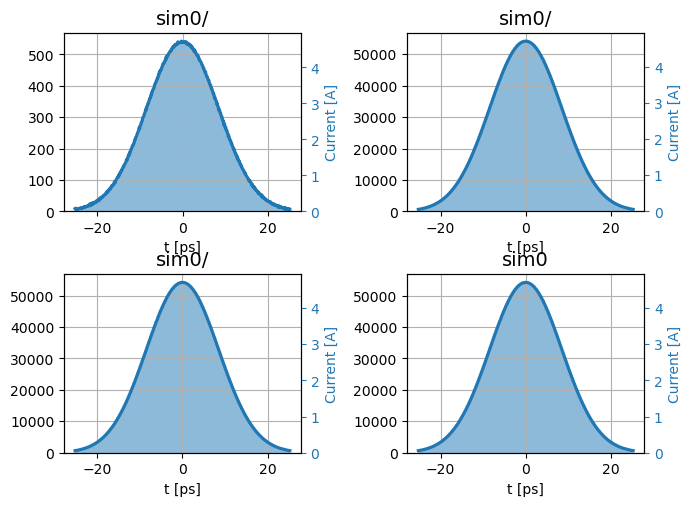

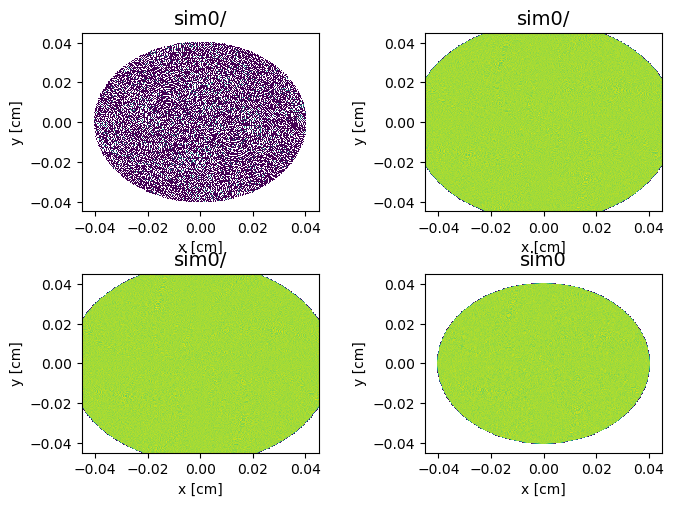

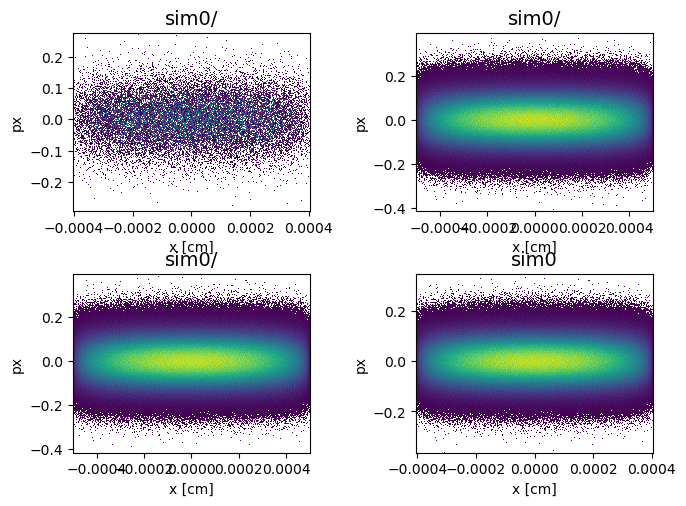

In [69]:
#histogram of input distribution
fig, axs = plt.subplots(nrows= nrows, ncols = ncols, figsize = figsize)
axs = axs.flatten()
plt.subplots_adjust(left=0.125, bottom=0.15, right=0.85 , top=0.85, wspace=0.45, hspace=0.35)
fig2, axs2 = plt.subplots(nrows= nrows, ncols = ncols, figsize = figsize)
axs2 = axs2.flatten()
plt.subplots_adjust(left=0.125, bottom=0.15, right=0.85 , top=0.85, wspace=0.45, hspace=0.35)

fig3, axs3 = plt.subplots(nrows= nrows, ncols = ncols, figsize = figsize)
axs3 = axs3.flatten()
plt.subplots_adjust(left=0.125, bottom=0.15, right=0.85 , top=0.85, wspace=0.45, hspace=0.35)
Q = 100e-12
print('Charge = %1.0f pC' %(Q*1e12))

for ind, path in enumerate(simdirs):
    os.chdir(path)
    dist = parse_opal_emitted_dist('opal_emitted.txt')
    print(len(dist['x']))
    axs[ind].hist(dist['t']*1e12, 220, alpha = 0.5)
    axs[ind].set_xlabel('t [ps]')
    #title =path.split(simdir)[1]
    title =  path.split(path.split('sim')[0])[1]
    if title == '/sim0.01': title = 'no perturbation'
    axs[ind].set_title(title, fontsize = 14)
    axs[ind].grid()
    #axs[ind].set_xlim(-42,42)
    
    ax = axs[ind].twinx()
    p = np.sqrt(1+dist['px']**2 + dist['py']**2)*dist['pz']
    print('check p, use open PMD')
      
    ts,I = getCurrent(dist['t'], p, Q = Q, Nbin = 500)
    ax.plot(ts*1e12, I, linewidth = 2.3)
    ax.set_ylabel('Current [A]', color = 'tab:blue')
    ax.xaxis.label.set_color('tab:blue')
    ax.tick_params(axis='y', colors='tab:blue')
    ax.set_ylim(0,)


    axs2[ind].hist2d(np.array(dist['x'])*100, np.array(dist['y'])*100, bins, cmin = 1)
    axs2[ind].set_ylabel('y [cm]')
    axs2[ind].set_xlabel('x [cm]')
    axs2[ind].set_title(title, fontsize = 14)
    title =  path.split(path.split('sim')[0])[1]
    if title == '/sim0.01': title = 'no perturbation'
    axs2[ind].set_title(title, fontsize = 14)
    axs2[ind].set_xlim(-0.045,0.045)
    axs2[ind].set_ylim(-0.045,0.045)

    axs3[ind].hist2d(dist['x'], dist['px']*100, bins, cmin = 1)
    axs3[ind].set_ylabel('px')
    axs3[ind].set_xlabel('x [cm]')
    axs3[ind].set_title(title, fontsize = 14)
    title =  path.split(path.split('sim')[0])[1]
    if title == '/sim0.01': title = 'no perturbation'
    axs3[ind].set_title(title, fontsize = 14)

In [66]:
for ind, path in enumerate(simdirs):
    os.chdir(path)
    dist = parse_opal_emitted_dist('opal_emitted.txt')
    keys = ['x', 'px']
    dd = np.array([ dist[key] for key in keys ])
    S = np.cov(dd)
    
    mc2_eV = 0.511e6
    Emean = 0.000018872e6 #MeV 
    av_gam = Emean/mc2_eV
    a = np.sqrt(np.linalg.det(S))*av_gam*1e6 #return in um

    Emean = 0.000018464e6 #centos
    av_gam = Emean/mc2_eV
    b = np.sqrt(np.linalg.det(S))*av_gam*1e6 #return in um

    print(path)
    print(a,b)
    

/sdf/data/ad/ard/u/paris/Cathode_shaping/test2/sim0/
5.218953808110861e-06 5.106123522306005e-06
/sdf/data/ad/ard/u/paris/Cathode_shaping/centos_sim0/
7.419661390696753e-06 7.259253280936033e-06
/sdf/data/ad/ard/u/paris/Cathode_shaping/benchmark_sim0/
7.419661390696753e-06 7.259253280936033e-06
/sdf/data/ad/ard/u/paris/Cathode_shaping/1pert_2pS_position5_100pC_comp_on/sim0
5.2188505054195e-06 5.106022452949642e-06
/sdf/data/ad/ard/u/paris/Cathode_shaping/benchmark_sim0_different_dist/
5.2188505054195e-06 5.106022452949642e-06


In [68]:
np.sqrt(5.106022452949642e-6/0.511e-6)

np.float64(3.1610466859232536)

In [60]:
7.2/5.1

1.411764705882353

In [63]:
250*1.41

352.5

In [62]:
330*1.41

465.29999999999995

In [43]:
len(dist['x'])

5000000

In [36]:
dist.keys()

dict_keys(['x', 'px', 'y', 'py', 't', 'pz'])

In [34]:
from h5py import File

get better parser from nicole
rms_s: 0.0009944617222382725
rms_x: 0.0001560031873295421
emit_x: 7.922102743577913e-07
get better parser from nicole
rms_s: 0.001032144771133762
rms_x: 0.000155722743998849
emit_x: 5.351324298667377e-07
get better parser from nicole
rms_s: 0.001032144771125618
rms_x: 0.0001557227439880987
emit_x: 5.35132429884181e-07
get better parser from nicole
rms_s: 0.0009642178239898568
rms_x: 0.0001107784656328906
emit_x: 8.088832703931126e-07


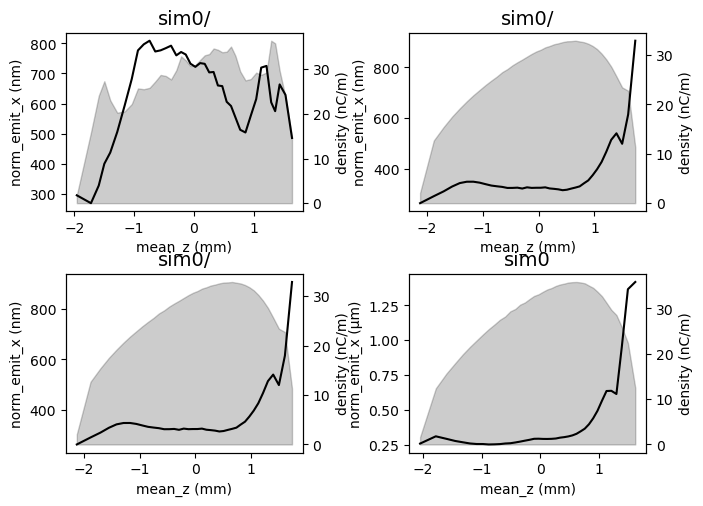

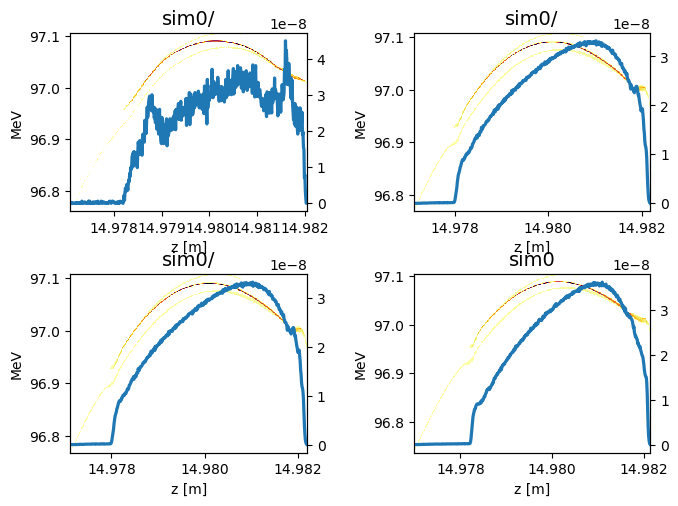

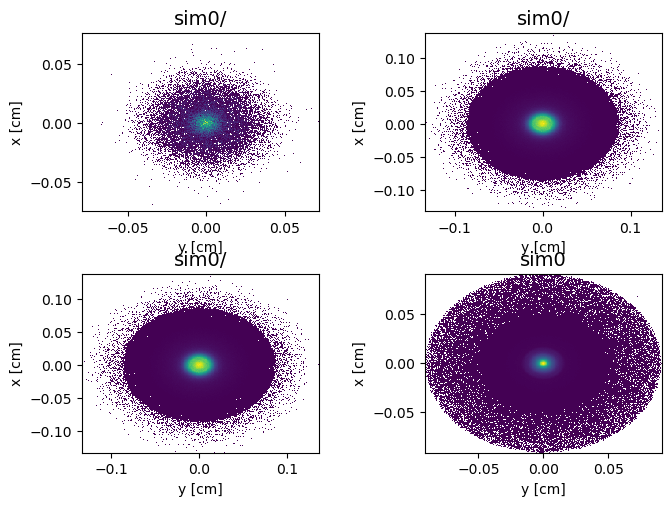

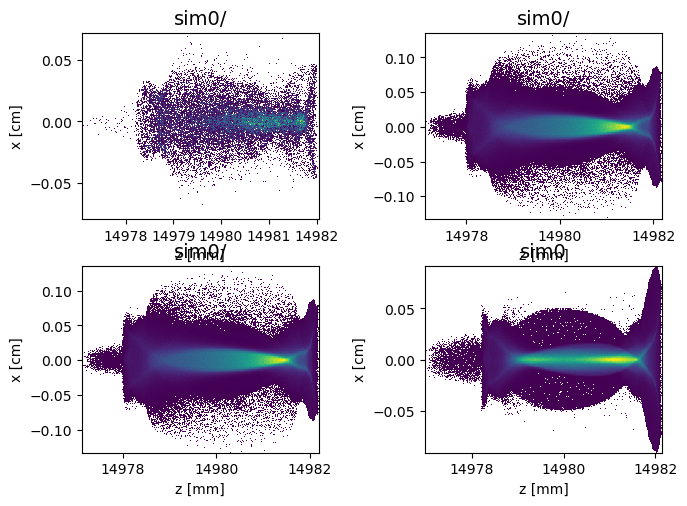

In [35]:
# nrows = 1
# ncols = 3
# figsize = (12,3)
fig, axs = plt.subplots(nrows= nrows, ncols = ncols, figsize = figsize)
axs = axs.flatten()
plt.subplots_adjust(left=0.125, bottom=0.15, right=0.85 , top=0.85, wspace=0.45, hspace=0.35)

fig2, axs2 = plt.subplots(nrows= nrows, ncols = ncols, figsize = figsize)
axs2 = axs2.flatten()
plt.subplots_adjust(left=0.125, bottom=0.15, right=0.85 , top=0.85, wspace=0.45, hspace=0.35)

fig3, axs3 = plt.subplots(nrows= nrows, ncols = ncols, figsize = figsize)
axs3 = axs3.flatten()

plt.subplots_adjust(left=0.125, bottom=0.15, right=0.85 , top=0.85, wspace=0.45, hspace=0.35)

fig4, axs4 = plt.subplots(nrows= nrows, ncols = ncols, figsize = figsize)
axs4 = axs4.flatten()

bins = 300

plt.subplots_adjust(left=0.125, bottom=0.15, right=0.85 , top=0.85, wspace=0.45, hspace=0.25)
for ind, path in enumerate(simdirs):
    os.chdir(path)
    h = File('sc_inj.h5', 'r')
    try:
        stat = parse_stat('sc_inj.stat')
    except:
        stat = old_parse_stat('sc_inj.stat')
    print('rms_s: ' + str(stat['rms_s'][-1]))
    print('rms_x: ' + str(stat['rms_x'][-1]))
    print('emit_x: ' + str(stat['emit_x'][-1]))
    last = len(h.keys())
    step = 'Step#'+str(last-1)
    step = 'Step#'+str(3)
    s = opal.opal_to_data(h[step])
    PG = ParticleGroup(data = s)
    PG.z = PG.z - PG['mean_z']
    slice_plot(PG, ax = axs[ind], stat_key = 'norm_emit_x', slice_key = 'z')
    try:
        title =path.split(simdir)[1]
    except:
        title =path.split(path.split('sim')[0])[1]
    if title == '/sim0.01': title = 'no perturbation'
    axs[ind].set_title(title, fontsize = 14)
    #axs[ind].set_ylim(axs[0].get_ylim()[0],600)
    
    axs2[ind].hist2d(np.array(s['z']), np.array(s['pz']*1e-6), bins, cmin = 1, cmap = 'inferno_r')
    axs2[ind].set_ylabel('MeV')
    axs2[ind].set_xlabel('z [m]')
    axs2[ind].set_title(title, fontsize = 14)
    ax = axs2[ind].twinx()
    zs,I = getCurrent(np.array(s['z']), np.array(s['pz']) , Q = PG['charge'], Nbin = 500) #does pz MATTER?
    ax.plot(zs, I, linewidth = 2.3)
    
    axs3[ind].hist2d(np.array(s['x'])*100, np.array(s['y'])*100, bins, cmin = 1)
    axs3[ind].set_ylabel('x [cm]')
    axs3[ind].set_xlabel('y [cm]')
    axs3[ind].set_title(title, fontsize = 14)
    
    axs4[ind].hist2d(np.array(s['z'])*1000, np.array(s['x'])*100, bins, cmin = 1)
    axs4[ind].set_xlabel('z [mm]')
    axs4[ind].set_ylabel('x [cm]')
    axs4[ind].set_title(title, fontsize = 14)
    
#plt.savefig(os.path.join(curdir, 'all_slice_dist.png'), bbox_inches = 'tight')

(0.0, 4.943641292443109)

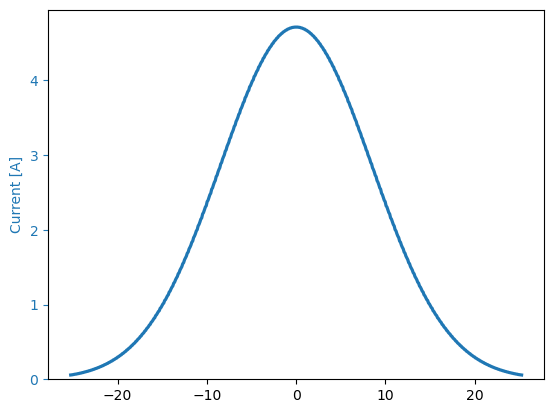

In [28]:
#histogram of input distribution
fig, axs = plt.subplots(nrows= nrows, ncols = ncols, figsize = figsize)
axs = axs.flatten()
plt.subplots_adjust(left=0.125, bottom=0.15, right=0.85 , top=0.85, wspace=0.45, hspace=0.35)
Q = 100e-12
print('Charge = %1.0f pC' %(Q*1e12))

for ind, path in enumerate(simdirs):
    os.chdir(path)
    dist = parse_opal_emitted_dist('opal_emitted.txt')
    axs[ind].hist(dist['t']*1e12, 220, alpha = 0.5)
    axs[ind].set_xlabel('t [ps]')
    #title =path.split(simdir)[1]
    title =  path.split(path.split('sim')[0])[1]
    if title == '/sim0.01': title = 'no perturbation'
    axs[ind].set_title(title, fontsize = 14)
    axs[ind].grid()
    #axs[ind].set_xlim(-42,42)
    
    ax = axs[ind].twinx()
    p = np.sqrt(1+dist['px']**2 + dist['py']**2)*dist['pz']
    print('check p, use open PMD')
      
    ts,I = getCurrent(dist['t'], p, Q = Q, Nbin = 500)
    ax.plot(ts*1e12, I, linewidth = 2.3)
    ax.set_ylabel('Current [A]', color = 'tab:blue')
    ax.xaxis.label.set_color('tab:blue')
    ax.tick_params(axis='y', colors='tab:blue')
    ax.set_ylim(0,)